# About

Solving the Kaggle "Getting started" competition [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) around the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

This challenge is a computer vision problem. As for other time-based series data, **Convolutional Neural Networks** CNN are very-well suited to solve this kind of problems.

This notebook's goal is four-fold:
* Help me integrate and apply theorical knowledge learnt from various sources ([Andrew Ng](https://www.coursera.org/learn/machine-learning), [Carlos Guestrin & Emily Fox](https://www.coursera.org/specializations/machine-learning), [Jeremy Howard](http://course.fast.ai/)).
* Learn to use [Keras](keras.io) and Theano/Tensorflow behind.
* Study and apply visualization techniques ([Christopher Olah](http://colah.github.io/)).
* Get more familiar with [Kaggle](http://colah.github.io/) and give back this notebook to the community.

# Setup

## Requirements

Numpy is useful for linear algebra

In [2]:
import numpy as np

Pandas is a great data structures and data analysis tool

In [3]:
import pandas as pd

Use matplotlib to visualize charts

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

[Keras](https://keras.io/) is a Deep Learning library, high-level framework on top of [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/).

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
import keras

Using TensorFlow backend.


## Load Data

Let's also import the [MNIST dataset](https://keras.io/datasets/#mnist-database-of-handwritten-digits) from Keras. There is no mention of tampering with the original data, and I checked on [the mnist db](http://yann.lecun.com/exdb/mnist/) that it should indeed consist of 28x28 grayscaled images, 60.000 training samples + 10.000 test samples.

In [96]:
from keras.datasets import mnist

* X_train: Training set, images input
* X_test: Test set, images input
* y_train: Labels output for training set
* y_test: Labels output for test set

In [97]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Let's visualize some data

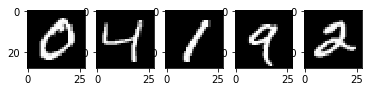

In [98]:
for i in range(1, 6):
    plt.subplot(150 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.rcParams["figure.figsize"] = [28,28]
plt.show();

and their corresponding value:

In [99]:
y_train[1:6]

array([0, 4, 1, 9, 2], dtype=uint8)

## Preprocessing

### 1-hot encoding

Let's represent our labels as 1-hot encoded vectors (create one feature for every possible output):

    1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    
**Note on Embeddings:** If we had categorical input, 1-hot encoding would allow us to easily multiply labels by coefficients. But this would be too slow. Keras has an **Embedding layer**, which takes an int as input, looks up a vector (instead of a huge matrix) and grabs the corresponding column as output. I won't use embeddings here since labels are an output and not an input.

In [100]:
from keras.utils.np_utils import to_categorical

In [101]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Verify that the new outputs match our five images above

In [102]:
for idx in range(1,6):
    print(y_train[idx].argmax(), ':', y_train[idx])

0 : [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4 : [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
1 : [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
9 : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
2 : [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


### Create sample

Working with 60000 images right off the bat might be overkill, especially on a laptop without GPU. The idea is to experiment with a small dataset, find a good-looking model, then go on AWS rent a p2.xlarge instance and run the model on the full dataset

In [35]:
mkdir data

mkdir: cannot create directory ‘data’: File exists


Let's work on a 1000-images sample

In [36]:
idx = np.random.randint(60000, size=1000)
X_sample = X_train[idx,:]
y_sample = y_train[idx,:]

split data into training and validation sets  (80/20 ratio)

In [46]:
idx = np.random.permutation(1000)
id_train, id_val = idx[:800], idx[800:]
Xs_train, Xs_val = X_sample[id_train,:], X_sample[id_val,:]
ys_train, ys_val = y_sample[id_train,:], y_sample[id_val,:]

Save sample so we can skip all previous parts and simply load the sample data from a file.

In [49]:
save_array('data/train_input_sample.bc', Xs_train)
save_array('data/valid_input_sample.bc', Xs_val)
save_array('data/train_output_sample.bc', ys_train)
save_array('data/valid_output_sample.bc', ys_val)

**FLAG: Restart from here**

In [14]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [15]:
Xs_train = load_array('data/train_input_sample.bc')
ys_train = load_array('data/train_output_sample.bc')
Xs_val = load_array('data/valid_input_sample.bc')
ys_val = load_array('data/valid_output_sample.bc')

Verify that we didn't mess up the dataset

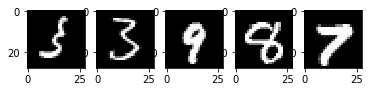

In [16]:
for i in range(1, 6):
    plt.subplot(150 + i)
    plt.imshow(Xs_train[i], cmap=plt.get_cmap('gray'))
plt.show();

In [17]:
for idx in range(1,6):
    print(ys_train[idx].argmax(), ':', ys_train[idx])

3 : [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
3 : [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
9 : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
8 : [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
7 : [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


### Batches

In [18]:
from keras.preprocessing import image

Let's create a mini-batch generator. This means that we'll only take a subset of all data during one iteration (epoch).


The Keras ImageDataGenerator creates mini-batches, and will allow us later to add **data augmentation** to our model. It expects a 4-dim array, so let's add a 4th dimension to our input

In [19]:
if len(Xs_train.shape) < 4:
    Xs_train = np.expand_dims(Xs_train, 4)
    Xs_val = np.expand_dims(Xs_val, 4)

In [20]:
gen = image.ImageDataGenerator()
batches = gen.flow(Xs_train, ys_train, batch_size=50)
test_batches = gen.flow(Xs_val, ys_val, batch_size=50)

# CNN VGG16

Since the [VGG model](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)'s layers are almost all convolutional, let's start working with this model. VGG16 is the smallest of the VGG family, hence the fastest to train, while still giving good results.

Keras has a [VGG16](https://keras.io/applications/#vgg16) model pre-trained on ImageNet.

In [21]:
#from keras.applications.vgg16 import VGG16

**Notes on VGG16:**
* puts 50% dropout after each of its dense layers (preferred flavor of regularization).
* isn't normalized (try [fast.ai Vgg16BN](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) later, should allow for higher learning rates)
* designed to create layers of gradually increasing complexity, which is good for transfer learning
* default input size is 224x224x3, and we cannot ask it to use an input shape of (28, 28, 1). We'll have to create our own version of VGG16

In [22]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense, Lambda

In [23]:
mean_px = Xs_train.mean().astype(np.float32)
std_px = Xs_train.std().astype(np.float32)
def norm_input(x): return (x-mean_px)/std_px

In [24]:
VGG16 = Sequential([
    Lambda(norm_input, input_shape=(28,28,1)),
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

We want to define a **Learning rate approach**. They all use the same theory: if the parameter that I’m changing, the derivative of that parameter is consistently of a very low magnitude, then if the derivative of this mini-batch is higher than that, what I really care about is the relative difference between how much this variable tends to change.

Let's use [**Adam**](https://keras.io/optimizers/#adam), which is RMSProp + Momentum, making training neural networks (NN) much faster.

Definitions:
* RMSProp: Divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight
* Momentum: Instead of using the gradient to change the position of the weight "particle", use it to change the velocity.

In [25]:
from keras.optimizers import Adam

We also need to specify a **Loss function**. We'll use **categorical crossentropy**

Definitions:
* Loss function: Usually a function defined on a data point (prediction and label), and measures the penalty. It's part of the cost function.
* Cross-entropy: Measure the distance between original probability score and resulting one-hot encoding.

**Note:** **Clipping** is very important for getting the best cross-entropy loss function

In [26]:
VGG16.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
VGG16.fit_generator(batches, steps_per_epoch=800//50,
                    validation_data=test_batches,
                    validation_steps=200//50,
                    epochs=3,
                    workers=1)

Epoch 1/3
16/16 [==============================] - 2s - loss: 3.2185e-04 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9750

97.5% accuracy on the validation test, looking good! 

In [82]:
VGG16.optimizer.lr=0.1

In [83]:
VGG16.fit_generator(batches, steps_per_epoch=800//50,
                    validation_data=test_batches,
                    validation_steps=200//50,
                    epochs=3,
                    workers=1)

Epoch 1/3
16/16 [==============================] - 2s - loss: 1.1589e-04 - acc: 1.0000 - val_loss: 0.0863 - val_acc: 0.9750

Decreasing the learning rate gives us a 99% accuracy on validation test!

## Predict test set

In [88]:
if len(X_test.shape) < 4:
    X_test = np.expand_dims(X_test, 4)
    
predictions = VGG16.predict(X_test)

In [98]:
mask = np.array([r.argmax() for r in predictions]) == np.array([r.argmax() for r in y_test])

In [101]:
len(mask)
sum(mask)

10000

9534

In [118]:
avg_preds = predictions.mean(axis=0)

In [116]:
avg_preds

array([ 0.1       ,  0.1       ,  0.09999999, ...,  0.1       ,
        0.09999999,  0.1       ], dtype=float32)

In [119]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": [r.argmax() for r in predictions]})
submissions.to_csv("DR.csv", index=False, header=True)

# Vizualizing MNIST with t-SNE

http://www.cs.toronto.edu/~hinton/absps/tsne.pdf

* way of converting a high-dimensional dataset into a matrix of pairwise similarities 
* t-SNE: technique to visualize the resulting similarities. t-Distributed Stochastic Neighbor Embedding


## Example TSNE

In [7]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
model.fit_transform(X) 

array([[ 0.00017599,  0.00003993],
       [ 0.00009891,  0.00021913],
       [ 0.00018554, -0.00009357],
       [ 0.00009528, -0.00001407]])

In [118]:
X_train[:1000].shape

(1000, 28, 28)

In [123]:
# Scale and visualize the embedding vectors
from matplotlib import offsetbox
import matplotlib.pyplot as plt


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        

digits = objectview({
    'data': X_train[:5000].reshape((5000, 28*28)),
    'images': X_train[:5000], #np.squeeze(X_train),
    'target': y_train[:5000],
})
from sklearn import datasets
#digits = datasets.load_digits()
X = digits.data
y = digits.target


def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i].argmax()),
                 color=plt.cm.Set1(y[i].argmax() / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)



Computing t-SNE embedding


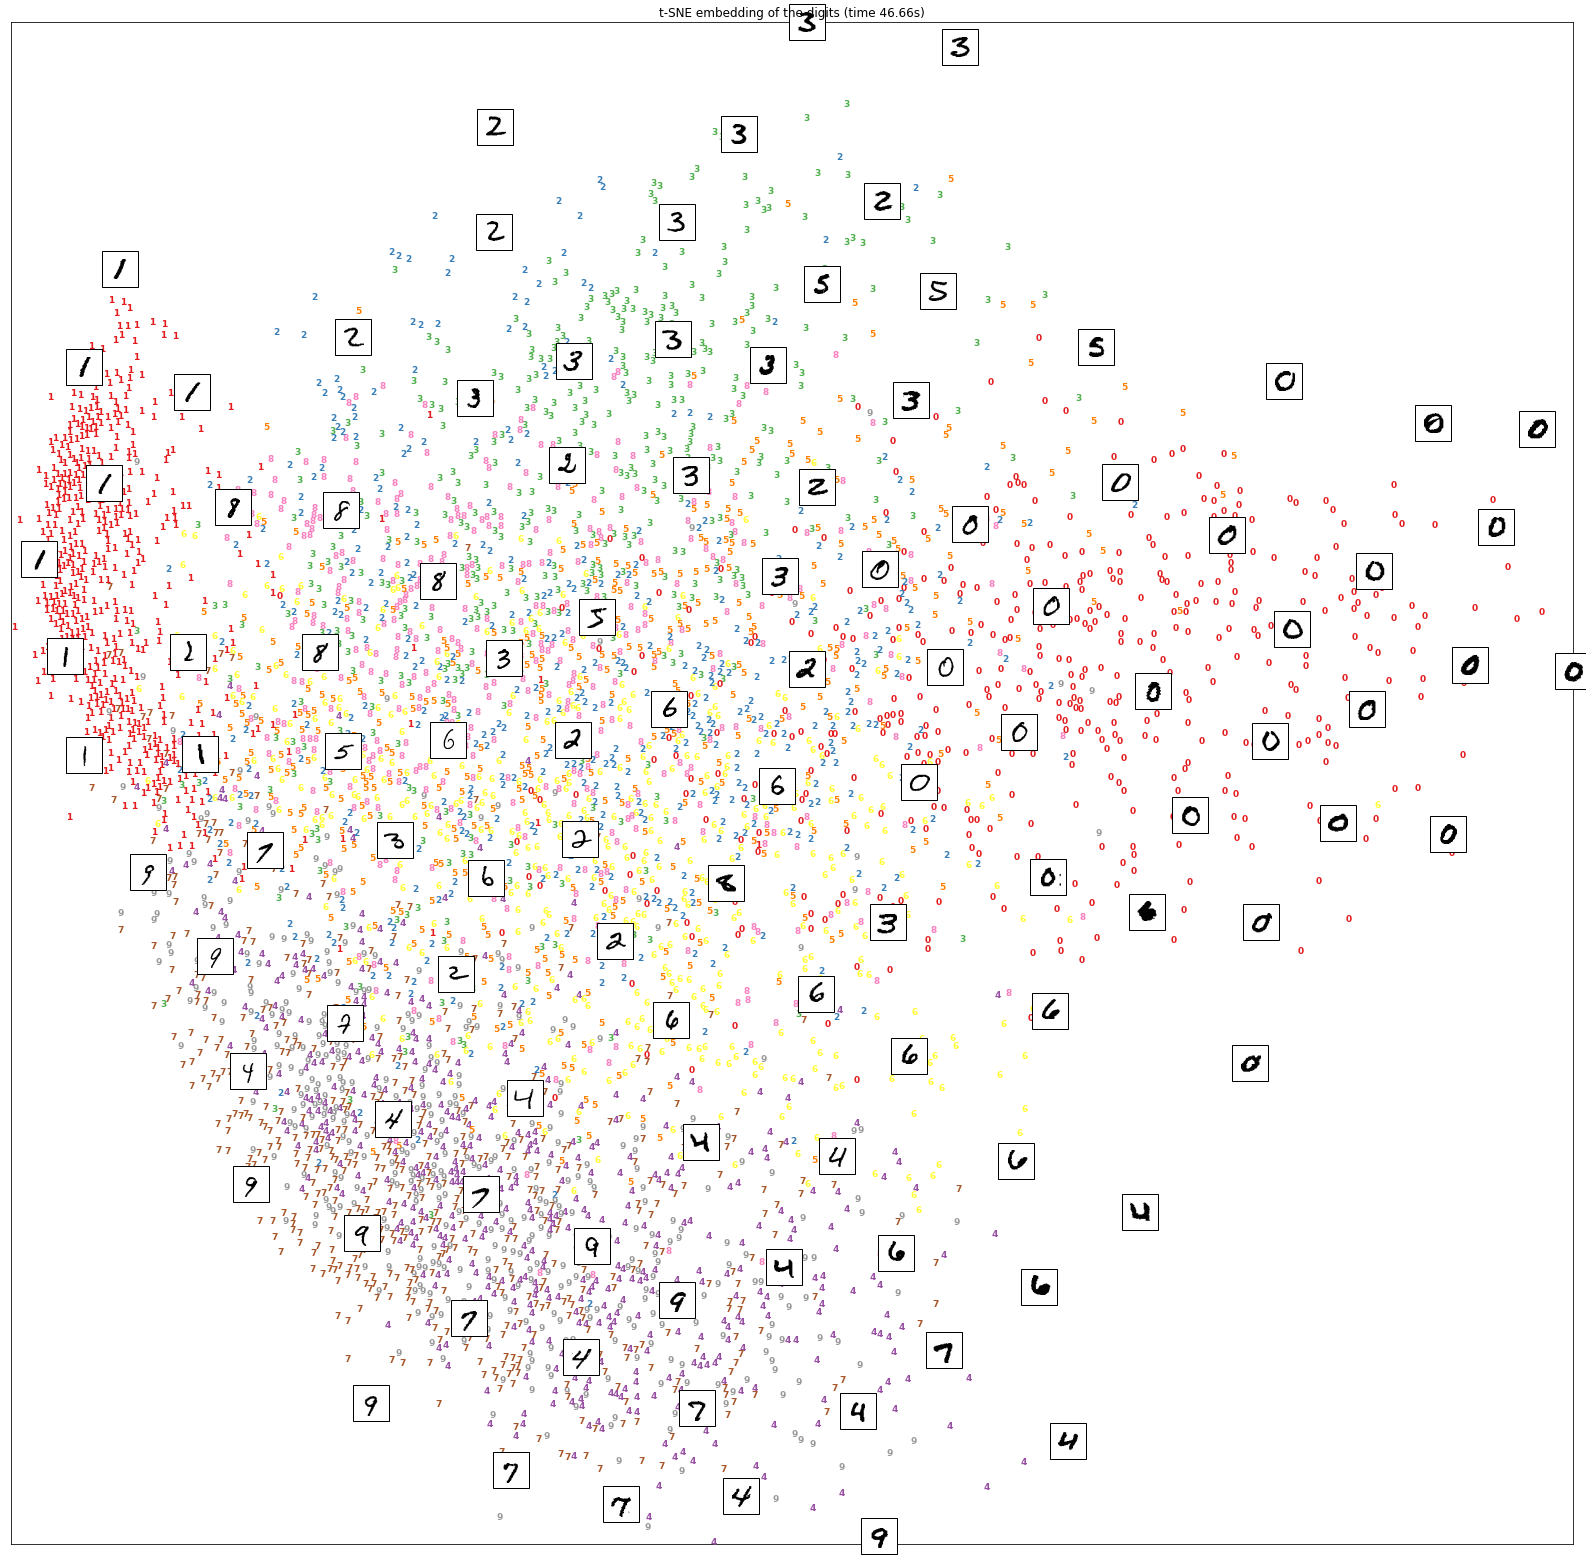

In [124]:
# t-SNE embedding of the digits dataset
from time import time
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()